[Split] q=2.3530 coverage=0.708 target=0.900


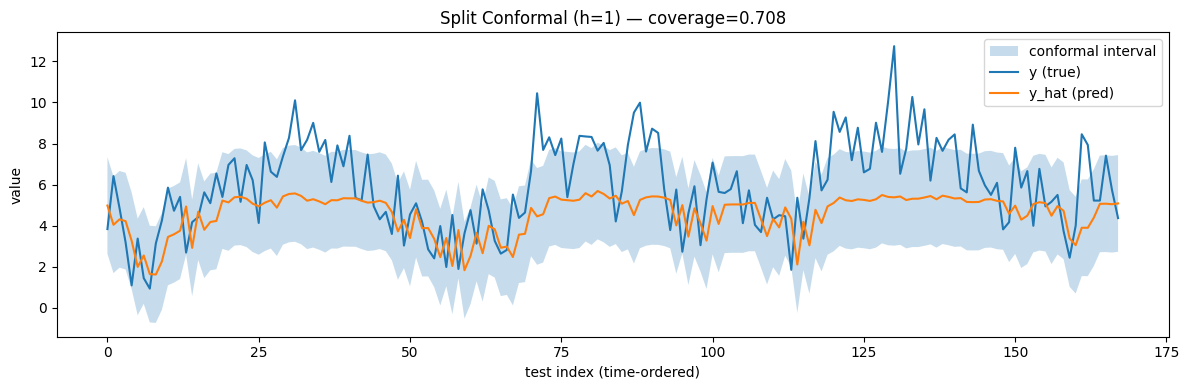

[Sliding] mean(q_t)=3.2472 coverage=0.863 target=0.900


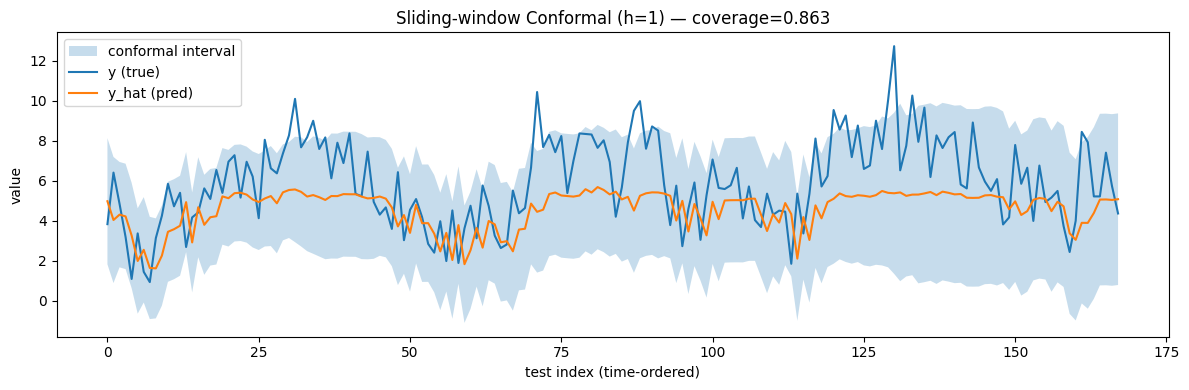

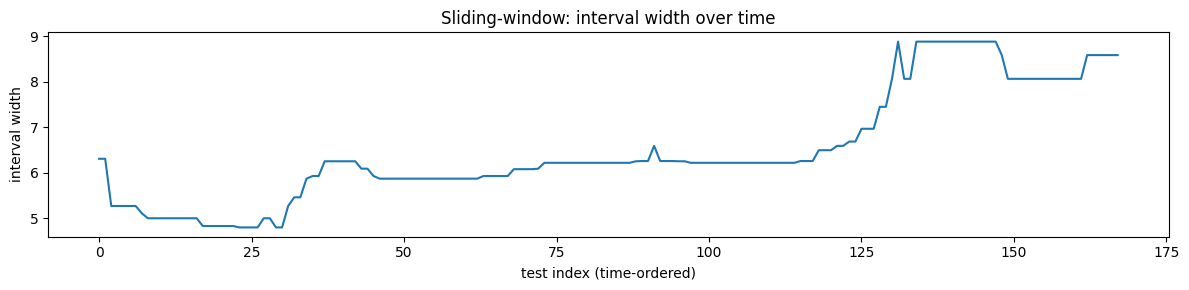

[CQR] q=1.3590 coverage=0.685 target=0.900


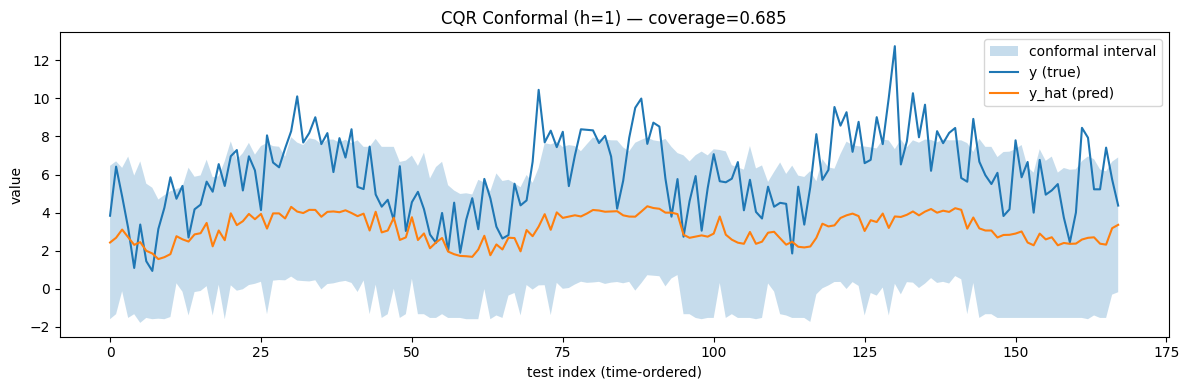

In [2]:
# Conformal prediction examples for time-series forecasting + plotting
# Adds matplotlib plots for:
# - Split conformal (single horizon)
# - Sliding-window conformal (single horizon)
# - CQR (asymmetric) (optional)
#
# Dependencies: numpy, scikit-learn, matplotlib
# pip install numpy scikit-learn matplotlib

from __future__ import annotations
import numpy as np
from dataclasses import dataclass
from typing import Callable, Tuple, Dict

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt


# ---------------------------------------------------------------------
# 0) Utilities
# ---------------------------------------------------------------------
def make_lagged_xy(y: np.ndarray, lags: int, horizon: int) -> Tuple[np.ndarray, np.ndarray]:
    y = np.asarray(y).astype(float)
    T = y.shape[0]
    N = T - lags - horizon + 1
    if N <= 0:
        raise ValueError("Not enough data for given lags and horizon.")
    X = np.stack([y[i : i + lags] for i in range(N)], axis=0)
    Y = y[lags + horizon - 1 : lags + horizon - 1 + N]
    return X, Y


def train_calib_test_split_time_order(X: np.ndarray, Y: np.ndarray, n_train: int, n_calib: int):
    if n_train + n_calib >= len(Y):
        raise ValueError("n_train + n_calib must be < number of samples.")
    X_train, Y_train = X[:n_train], Y[:n_train]
    X_cal, Y_cal = X[n_train : n_train + n_calib], Y[n_train : n_train + n_calib]
    X_test, Y_test = X[n_train + n_calib :], Y[n_train + n_calib :]
    return (X_train, Y_train), (X_cal, Y_cal), (X_test, Y_test)


def conformal_q(residuals: np.ndarray, alpha: float) -> float:
    r = np.sort(np.asarray(residuals).astype(float))
    n = r.size
    if n == 0:
        raise ValueError("Empty residuals.")
    k = int(np.ceil((n + 1) * (1 - alpha)))
    k = min(max(k, 1), n)
    return float(r[k - 1])


def coverage(y_true: np.ndarray, lo: np.ndarray, hi: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    lo = np.asarray(lo)
    hi = np.asarray(hi)
    return float(np.mean((y_true >= lo) & (y_true <= hi)))


# ---------------------------------------------------------------------
# 1) Example data
# ---------------------------------------------------------------------
def make_synth_series(T: int = 700, seed: int = 0) -> np.ndarray:
    rng = np.random.default_rng(seed)
    t = np.arange(T, dtype=float)
    trend = 0.01 * t
    season = 2.0 * np.sin(2 * np.pi * t / 50.0) + 0.5 * np.sin(2 * np.pi * t / 10.0)
    sigma = 0.2 + 0.002 * t  # heteroskedastic noise
    noise = rng.normal(0.0, sigma)
    return trend + season + noise


# ---------------------------------------------------------------------
# 2) Split Conformal (single horizon)
# ---------------------------------------------------------------------
def split_conformal_forecast_intervals(
    y: np.ndarray,
    *,
    lags: int = 32,
    horizon: int = 1,
    n_train: int = 350,
    n_calib: int = 150,
    alpha: float = 0.1,
    model_factory: Callable[[], object] = lambda: RandomForestRegressor(
        n_estimators=300, random_state=0, min_samples_leaf=2
    ),
) -> Dict[str, np.ndarray]:
    X, Y = make_lagged_xy(y, lags=lags, horizon=horizon)
    (Xtr, Ytr), (Xcal, Ycal), (Xte, Yte) = train_calib_test_split_time_order(
        X, Y, n_train=n_train, n_calib=n_calib
    )

    model = model_factory()
    model.fit(Xtr, Ytr)

    Ycal_hat = model.predict(Xcal)
    resid = np.abs(Ycal - Ycal_hat)
    q = conformal_q(resid, alpha=alpha)

    Yte_hat = model.predict(Xte)
    lo = Yte_hat - q
    hi = Yte_hat + q

    return dict(y_test=Yte, y_hat=Yte_hat, lo=lo, hi=hi, q=np.array([q]))


# ---------------------------------------------------------------------
# 3) Sliding-window Conformal (single horizon)
# ---------------------------------------------------------------------
def sliding_window_conformal_intervals(
    y: np.ndarray,
    *,
    lags: int = 32,
    horizon: int = 1,
    n_train: int = 350,
    n_calib: int = 150,
    alpha: float = 0.1,
    window: int = 60,
    model_factory: Callable[[], object] = lambda: RandomForestRegressor(
        n_estimators=300, random_state=0, min_samples_leaf=2
    ),
) -> Dict[str, np.ndarray]:
    X, Y = make_lagged_xy(y, lags=lags, horizon=horizon)
    (Xtr, Ytr), (Xcal, Ycal), (Xte, Yte) = train_calib_test_split_time_order(
        X, Y, n_train=n_train, n_calib=n_calib
    )

    model = model_factory()
    model.fit(Xtr, Ytr)

    Ycal_hat = model.predict(Xcal)
    resid_hist = np.abs(Ycal - Ycal_hat)

    Yte_hat = model.predict(Xte)
    lo = np.empty_like(Yte_hat, dtype=float)
    hi = np.empty_like(Yte_hat, dtype=float)
    q_t = np.empty_like(Yte_hat, dtype=float)

    for i in range(len(Yte_hat)):
        recent = resid_hist[-window:] if resid_hist.size >= window else resid_hist
        q = conformal_q(recent, alpha=alpha)
        q_t[i] = q
        lo[i] = Yte_hat[i] - q
        hi[i] = Yte_hat[i] + q

        # online update (simulate streaming reveal)
        resid_hist = np.append(resid_hist, abs(Yte[i] - Yte_hat[i]))

    return dict(y_test=Yte, y_hat=Yte_hat, lo=lo, hi=hi, q_t=q_t)


# ---------------------------------------------------------------------
# 4) CQR (asymmetric) optional
# ---------------------------------------------------------------------
def cqr_intervals(
    y: np.ndarray,
    *,
    lags: int = 32,
    horizon: int = 1,
    n_train: int = 350,
    n_calib: int = 150,
    alpha: float = 0.1,
) -> Dict[str, np.ndarray]:
    tau_lo = alpha / 2.0
    tau_hi = 1.0 - alpha / 2.0

    X, Y = make_lagged_xy(y, lags=lags, horizon=horizon)
    (Xtr, Ytr), (Xcal, Ycal), (Xte, Yte) = train_calib_test_split_time_order(
        X, Y, n_train=n_train, n_calib=n_calib
    )

    m_lo = GradientBoostingRegressor(loss="quantile", alpha=tau_lo, random_state=0)
    m_hi = GradientBoostingRegressor(loss="quantile", alpha=tau_hi, random_state=0)
    m_lo.fit(Xtr, Ytr)
    m_hi.fit(Xtr, Ytr)

    l_cal = m_lo.predict(Xcal)
    u_cal = m_hi.predict(Xcal)
    s = np.maximum.reduce([Ycal - u_cal, l_cal - Ycal, np.zeros_like(Ycal)])

    q = conformal_q(s, alpha=alpha)

    l_te = m_lo.predict(Xte)
    u_te = m_hi.predict(Xte)

    lo = l_te - q
    hi = u_te + q

    return dict(y_test=Yte, lo=lo, hi=hi, l_hat=l_te, u_hat=u_te, q=np.array([q]))


# ---------------------------------------------------------------------
# 5) Plotting helpers
# ---------------------------------------------------------------------
def plot_pred_and_interval(
    y_true: np.ndarray,
    y_hat: np.ndarray,
    lo: np.ndarray,
    hi: np.ndarray,
    *,
    title: str,
    max_points: Optional[int] = 300,
):
    """
    Plots y_true, y_hat, and shaded interval [lo, hi].
    """
    y_true = np.asarray(y_true)
    y_hat = np.asarray(y_hat)
    lo = np.asarray(lo)
    hi = np.asarray(hi)

    n = len(y_true)
    if max_points is not None and n > max_points:
        idx = np.arange(n - max_points, n)
    else:
        idx = np.arange(n)

    plt.figure(figsize=(12, 4))
    plt.fill_between(idx, lo[idx], hi[idx], alpha=0.25, label="conformal interval")
    plt.plot(idx, y_true[idx], linewidth=1.5, label="y (true)")
    plt.plot(idx, y_hat[idx], linewidth=1.5, label="y_hat (pred)")
    plt.title(title)
    plt.xlabel("test index (time-ordered)")
    plt.ylabel("value")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_interval_width(
    lo: np.ndarray,
    hi: np.ndarray,
    *,
    title: str,
    max_points: Optional[int] = 300,
):
    """
    Plots interval width over time (useful to see adaptivity).
    """
    lo = np.asarray(lo)
    hi = np.asarray(hi)
    width = hi - lo
    n = len(width)
    if max_points is not None and n > max_points:
        idx = np.arange(n - max_points, n)
    else:
        idx = np.arange(n)

    plt.figure(figsize=(12, 3))
    plt.plot(idx, width[idx], linewidth=1.5)
    plt.title(title)
    plt.xlabel("test index (time-ordered)")
    plt.ylabel("interval width")
    plt.tight_layout()
    plt.show()


# ---------------------------------------------------------------------
# 6) Run + plot
# ---------------------------------------------------------------------
if __name__ == "__main__":
    y = make_synth_series(T=700, seed=0)
    alpha = 0.1

    # Split conformal
    res = split_conformal_forecast_intervals(
        y, lags=32, horizon=1, n_train=350, n_calib=150, alpha=alpha
    )
    cov = coverage(res["y_test"], res["lo"], res["hi"])
    print(f"[Split] q={res['q'][0]:.4f} coverage={cov:.3f} target={1-alpha:.3f}")
    plot_pred_and_interval(res["y_test"], res["y_hat"], res["lo"], res["hi"],
                           title=f"Split Conformal (h=1) — coverage={cov:.3f}")

    # Sliding-window conformal
    res2 = sliding_window_conformal_intervals(
        y, lags=32, horizon=1, n_train=350, n_calib=150, alpha=alpha, window=60
    )
    cov2 = coverage(res2["y_test"], res2["lo"], res2["hi"])
    print(f"[Sliding] mean(q_t)={res2['q_t'].mean():.4f} coverage={cov2:.3f} target={1-alpha:.3f}")
    plot_pred_and_interval(res2["y_test"], res2["y_hat"], res2["lo"], res2["hi"],
                           title=f"Sliding-window Conformal (h=1) — coverage={cov2:.3f}")
    plot_interval_width(res2["lo"], res2["hi"], title="Sliding-window: interval width over time")

    # CQR (asymmetric)
    res3 = cqr_intervals(
        y, lags=32, horizon=1, n_train=350, n_calib=150, alpha=alpha
    )
    cov3 = coverage(res3["y_test"], res3["lo"], res3["hi"])
    print(f"[CQR] q={res3['q'][0]:.4f} coverage={cov3:.3f} target={1-alpha:.3f}")

    # For plotting, pick a representative "prediction" as mid of quantile band
    y_hat_cqr = 0.5 * (res3["l_hat"] + res3["u_hat"])
    plot_pred_and_interval(res3["y_test"], y_hat_cqr, res3["lo"], res3["hi"],
                           title=f"CQR Conformal (h=1) — coverage={cov3:.3f}")